**Transformer Architecture**

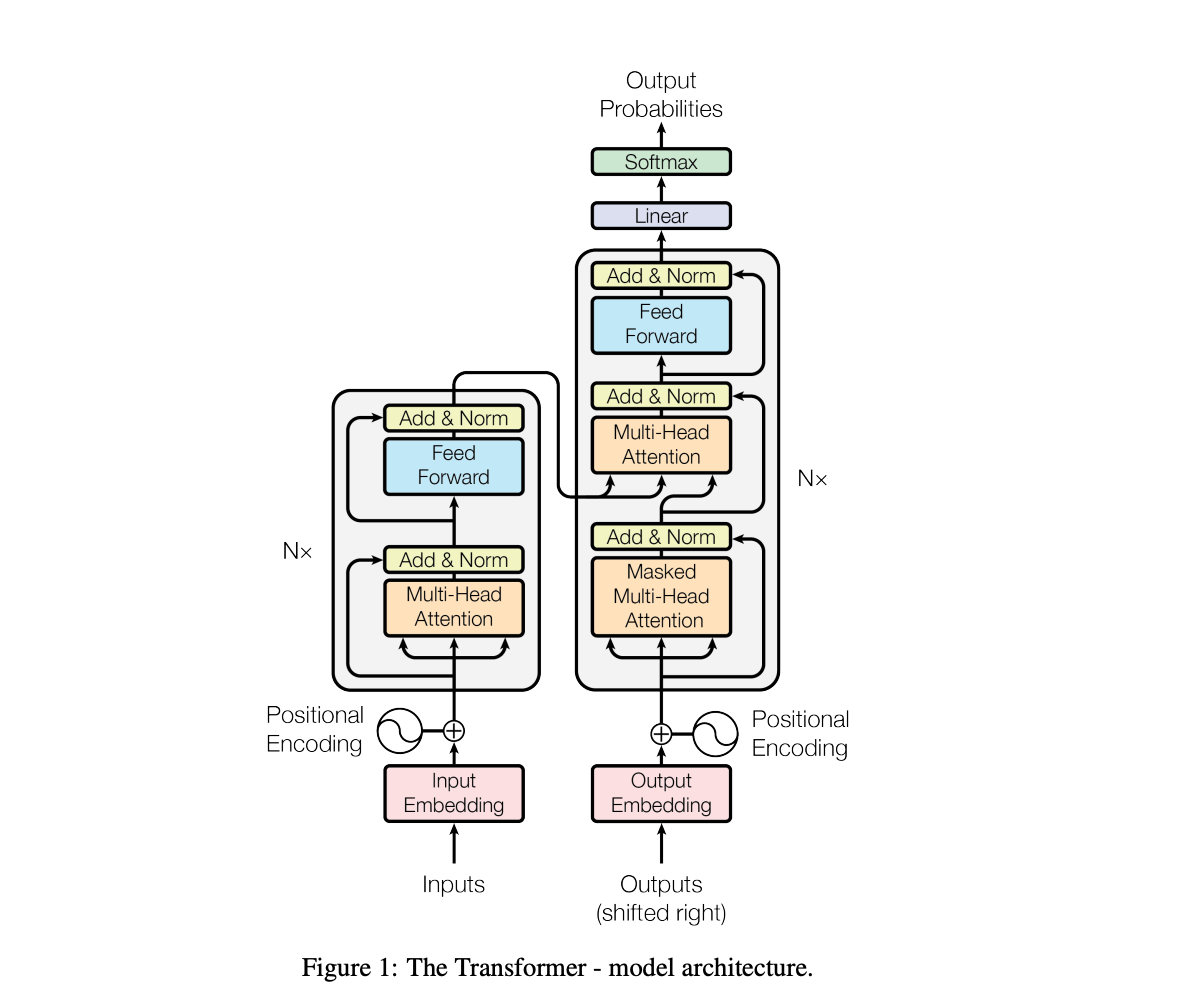

**Workflow**


1. Importing Libraries
2. Input Embedding
3. Positional Encoding
4. Multihead Attention (Self Attention)
5. Add and Norm (Layer Normalization)
6. Feed Forward Network
7. Residual Connection
8. Encoder
9. Decoder
10. Building a Transformer
11. Test the Transformer
12. Tokenizer
13. Loading Dataset
14. Validation Loop
15. Training Loop
16. Conclusion


1. **Importing Libraries**

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
# Math
import math
# HuggingFace Libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
# Pathlib
from pathlib import Path
# Typing
from typing import Any
# Library for progress bars in loops
from tqdm import tqdm
# Importing libraries of warnings
import warnings

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.11/bin/python3.11


2. **Input Embedding**

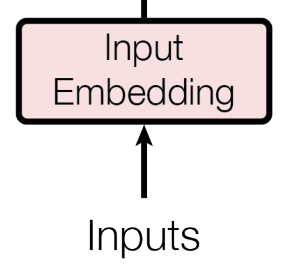

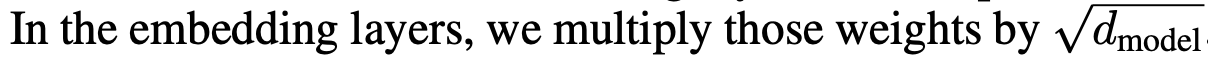

d_model=512

**English sentence** : I had a guitar and it was red in color.

**Tokens** : I, had, a, guitar, and, it, was, red, in, color

**Vocabulary** : a=0, it=1, in=2, the=3, was=4, had=5, has=6, color=7, guitar=8, I=9

In [3]:
 class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int,vocab_size: int):
        super.__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

        def forward(self, x):
            return self.embedding(x) * math.sqrt(self.d_model)
      

max_sequence_length = 10, <br> embedding_dim = 512

3. **Positional Encoding**

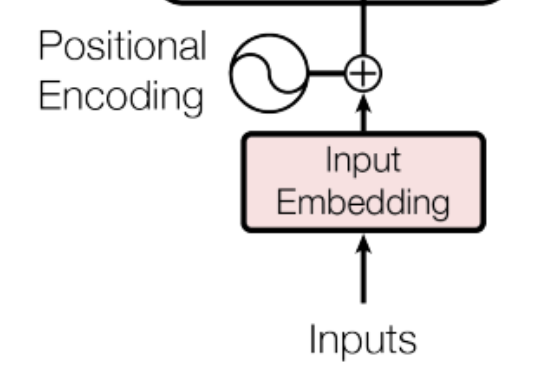

Positional encodings have the same dimension d_model as the embeddings so that the two can be summer.

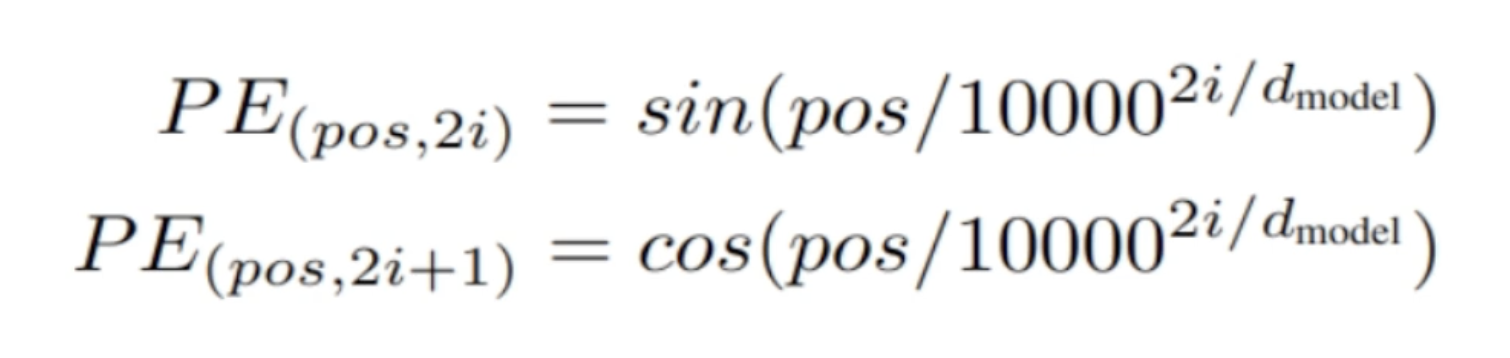

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.seq_len = seq_len
        
        pe=torch.zeros(seq_len, d_model)
        position=torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

        div_term=torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        def forward(self, x):
            x = x + self.pe[:, :x.shape[1], :].require_grad_(False)
            return self.dropout(x)

3. **MultiHead Attention (Self Attention)**

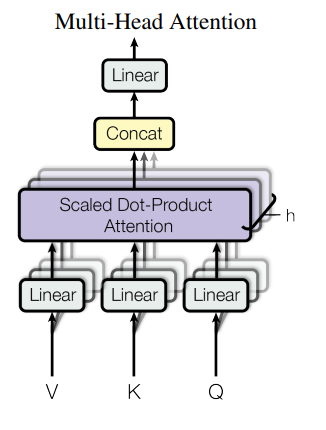

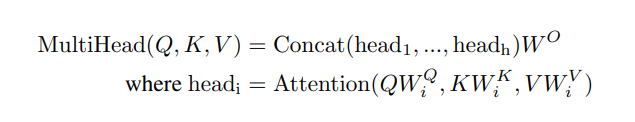

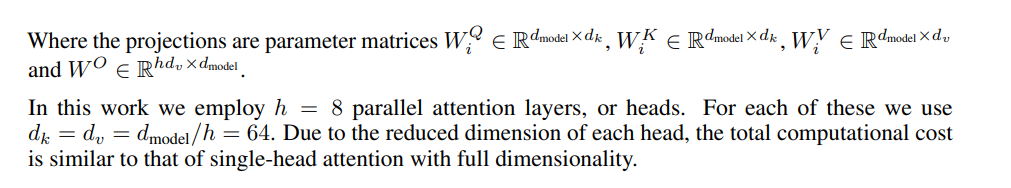

**Importing all libraries for our model**

In [13]:
# all the important liberires from pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [14]:
import math

In [15]:
#HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [16]:
#pathlib
from pathlib import Path

In [17]:
#typing
from typing import Any

In [18]:
#Library for progress bars in loops
from tqdm import tqdm

In [19]:
#importing library of warnings
import warnings

***Input Embeddings***

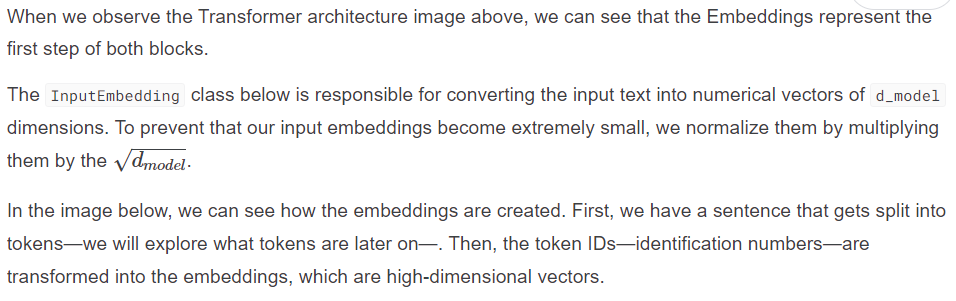

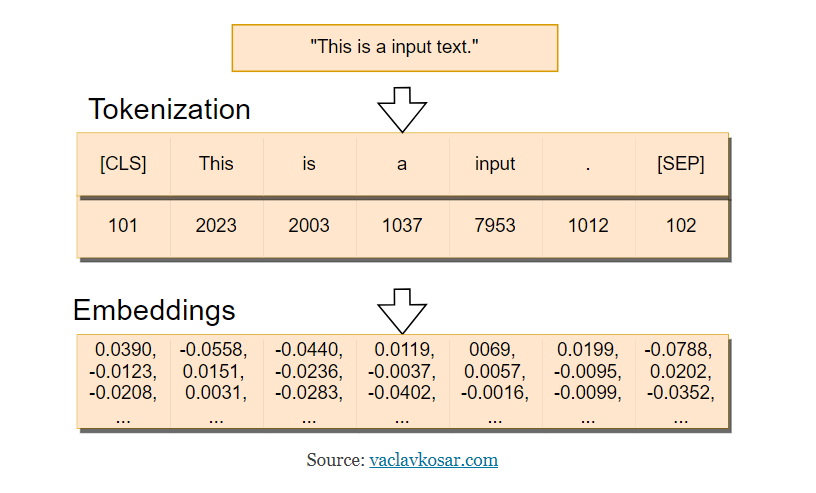

In [20]:
# Creating Input Embeddings
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model # Dimension of vectors (512)
        self.vocab_size = vocab_size # Size of the vocabulary
        self.embedding = nn.Embedding(vocab_size, d_model) # PyTorch layer that converts integer indices to dense embeddings

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) # Normalizing the variance of the embedding

***Positional Encoding***

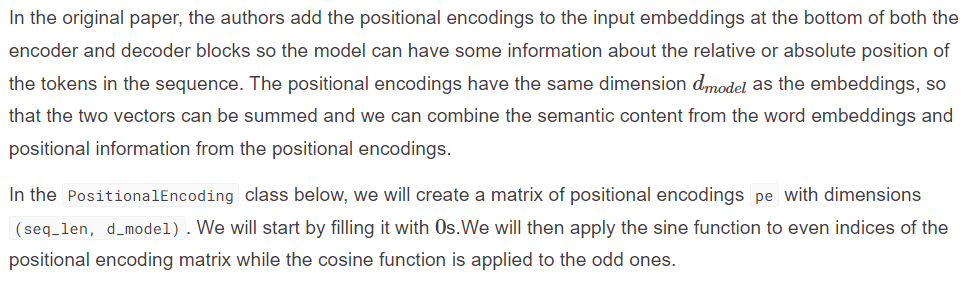

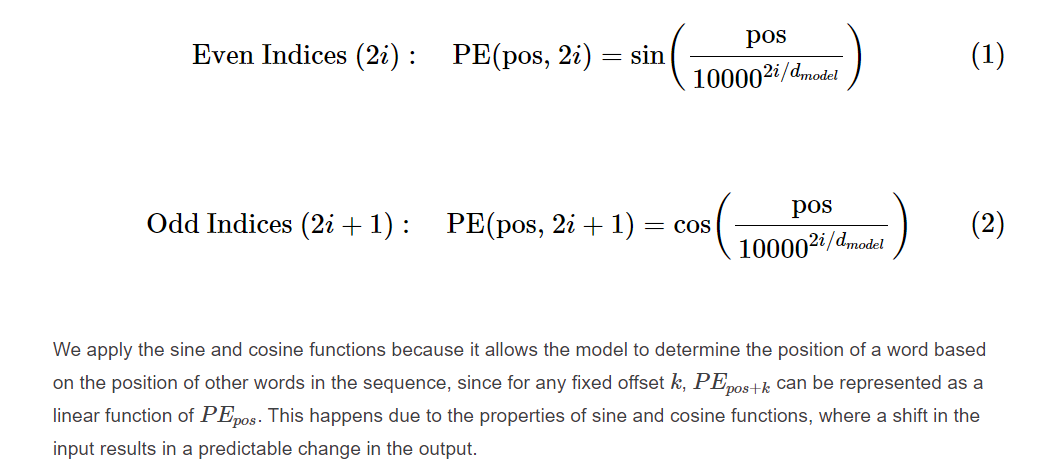

*Why do we have self buffer here?*

If you have parameters in your model, which should be saved and restored in the state_dict, but not trained by the optimizer, you should register them as buffers. Buffers won’t be returned in model.parameters(), so that the optimizer won’t have a change to update them. # register_buffer => Tensor which is not a parameter, but should be part of the modules state. # Used for tensors that need to be on the same device as the module. # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)

In [21]:
# Creating the Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting

        # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
        pe = torch.zeros(seq_len, d_model)

        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']

        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization

**Layer Normalization**

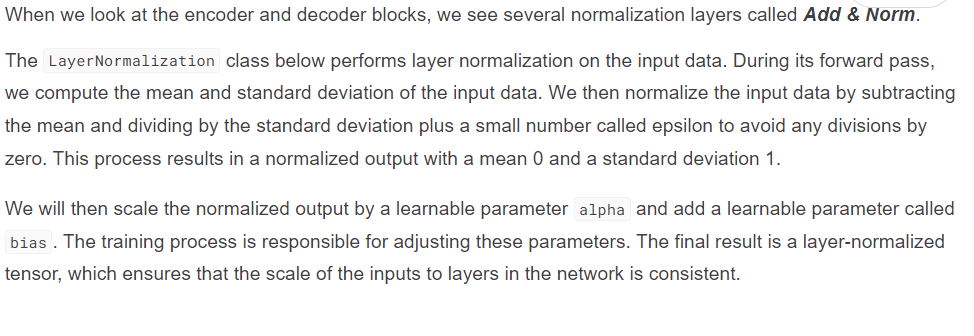

In [22]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1)) # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

**Feed Forward Network**

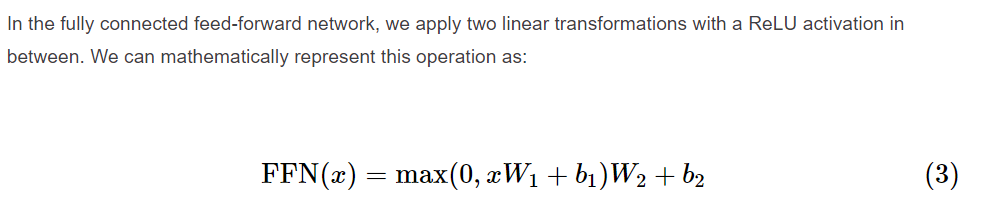

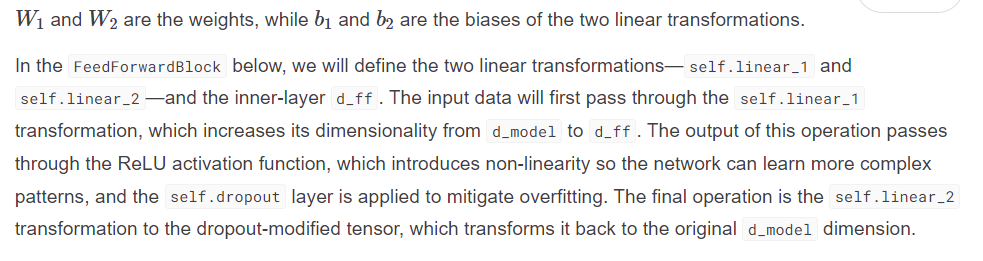

In [23]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
        self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2

    def forward(self, x):
        # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

**Multihead Attention**

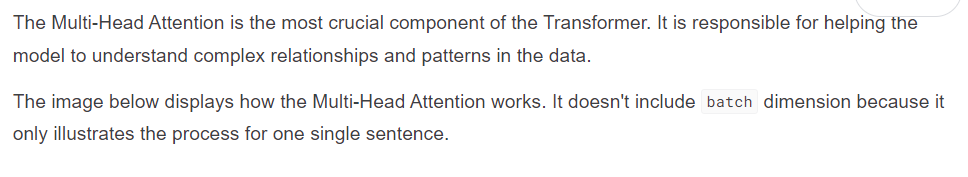

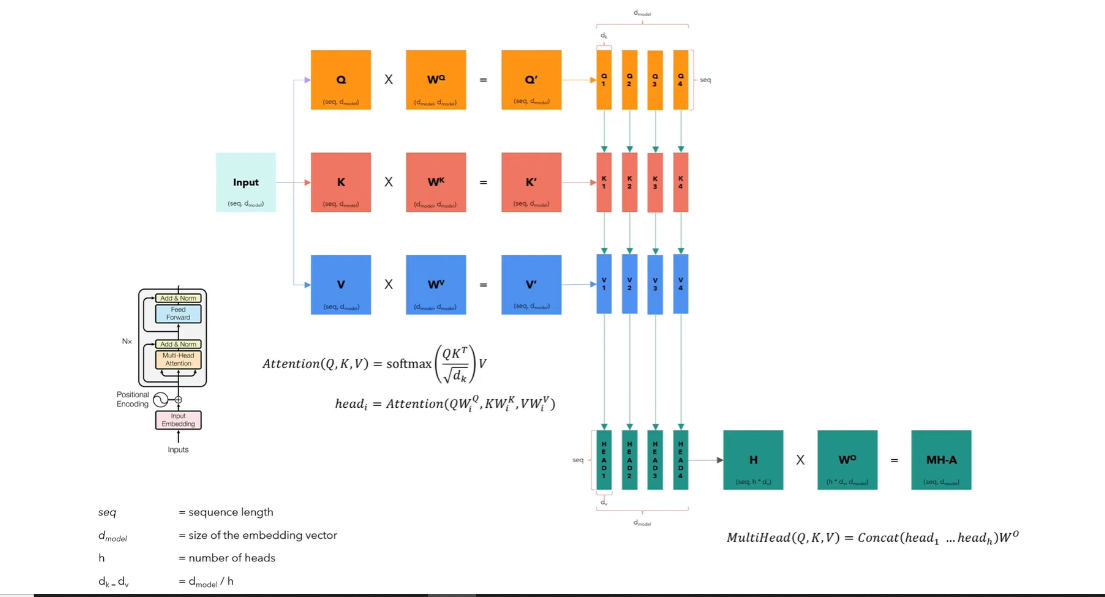

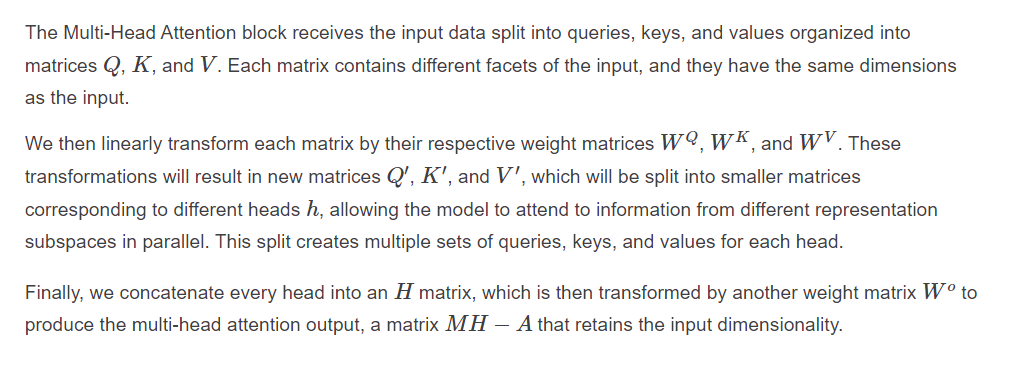

In [24]:
# Creating the Multi-Head Attention block
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisible by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper

        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o

        self.dropout = nn.Dropout(dropout) # Dropout layer to avoid overfitting


    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):# mask => When we want certain words to NOT interact with others, we "hide" them

        d_k = query.shape[-1] # The last dimension of query, key, and value

        # We calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k) # @ = Matrix multiplication sign in PyTorch

        # Before applying the softmax, we apply the mask to hide some interactions between words
        if mask is not None: # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9
        attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
        if dropout is not None: # If a dropout IS defined...
            attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

        return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula

    def forward(self, q, k, v, mask):

        query = self.w_q(q) # Q' matrix
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix


        # Splitting results into smaller matrices for the different heads
        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

        # Obtaining the output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # Obtaining the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix

***Residual Connection***

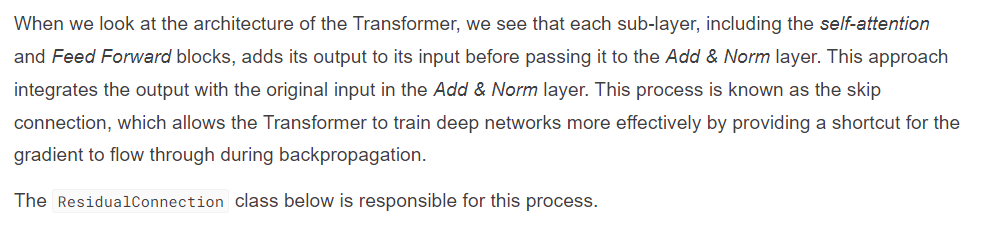

In [25]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
        self.norm = LayerNormalization() # We use a normalization layer

    def forward(self, x, sublayer):
        # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
        return x + self.dropout(sublayer(self.norm(x)))

**Encoder**

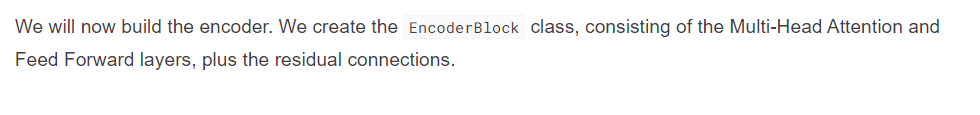

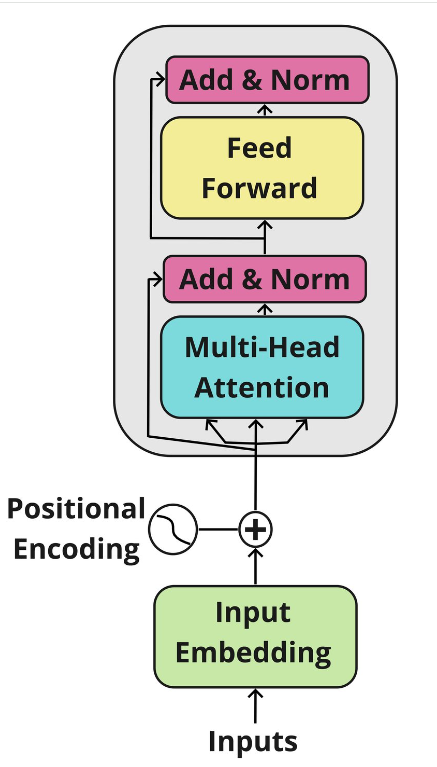

In [26]:
# Building Encoder Block
class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.

In [27]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):

    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

**Decoder**

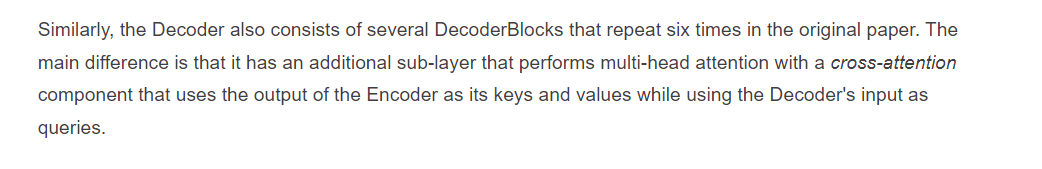

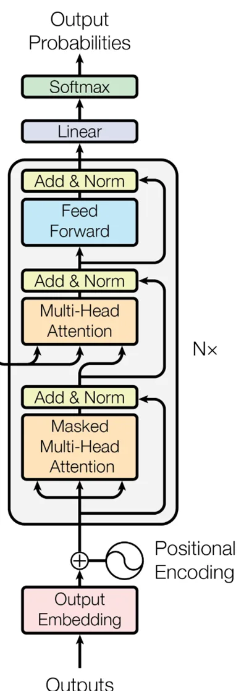

In [28]:
# Building Decoder Block
class DecoderBlock(nn.Module):

    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [29]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):

    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        # Storing the 'DecoderBlock's
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output

*Projection Layer*

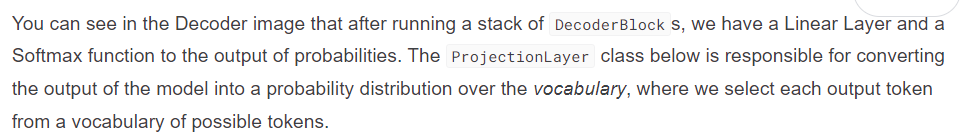

In [30]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output

**Building the Transformer**

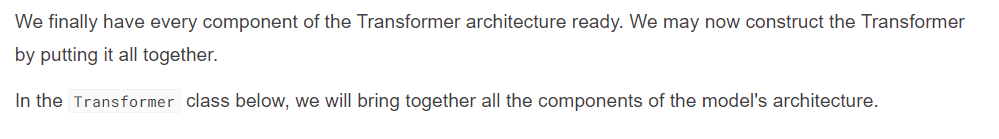

In [31]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

**Initializing the transformer**

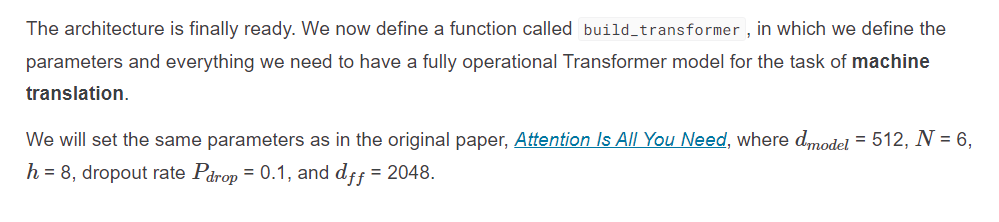

In [32]:
# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

Model is now ready to be trained

**Tokenization**

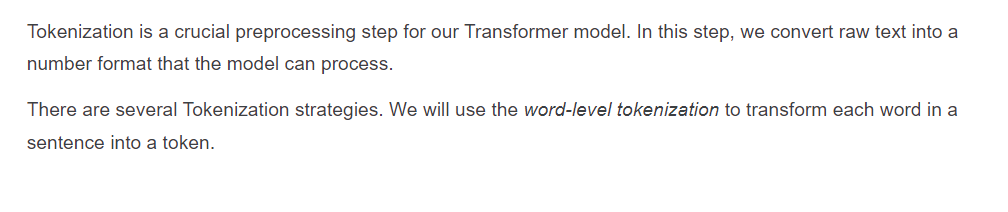

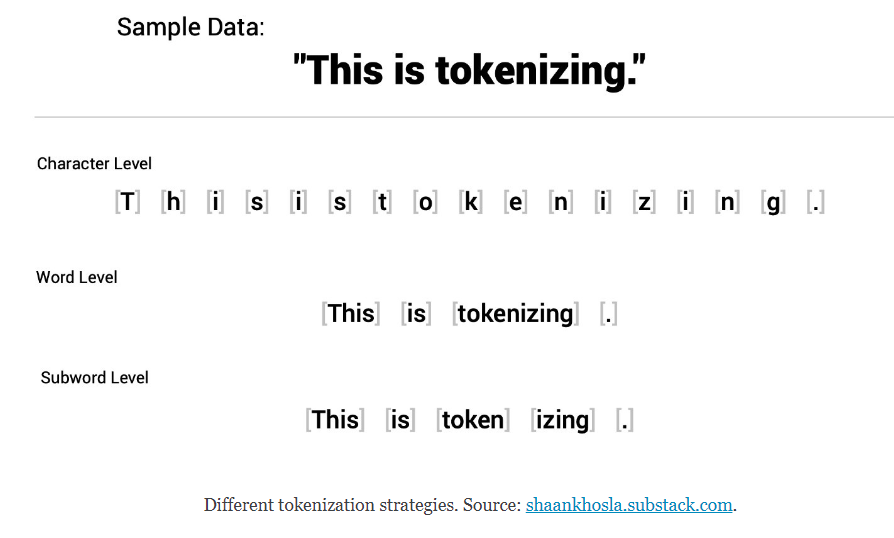

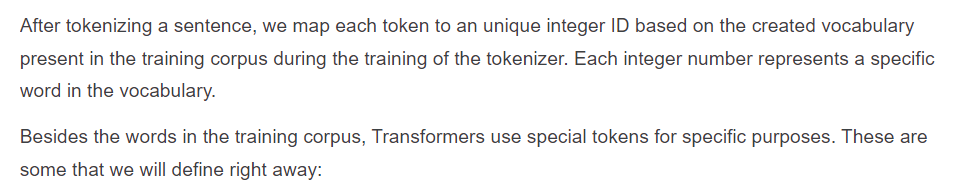

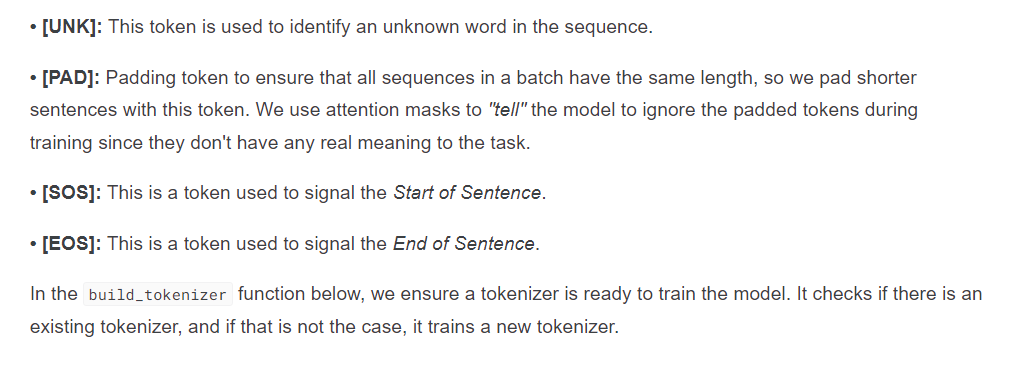

In [33]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

**Loading Datasets**

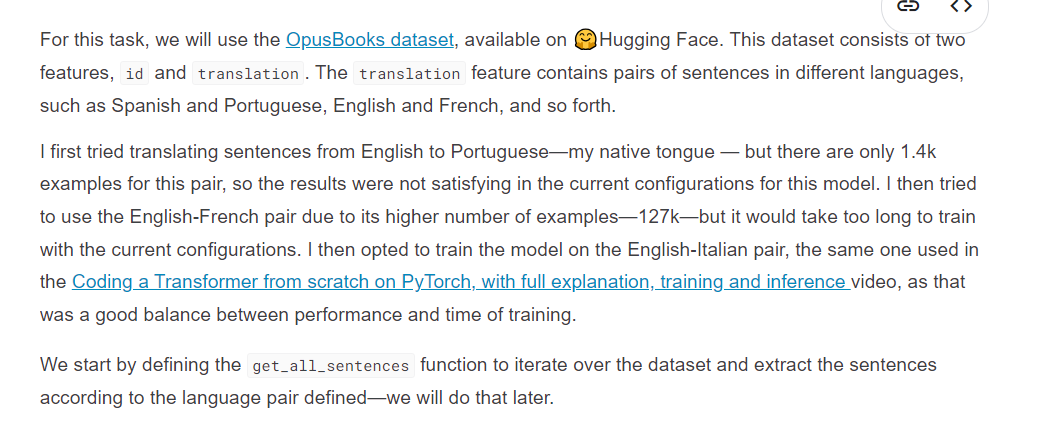

In [34]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

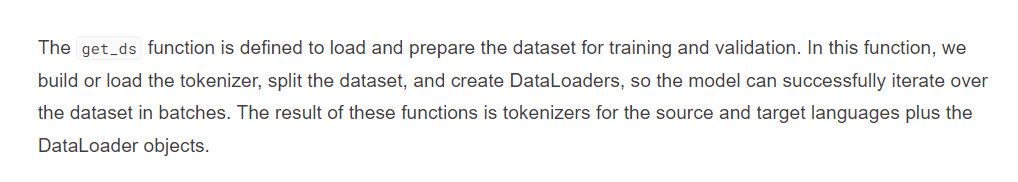

In [35]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

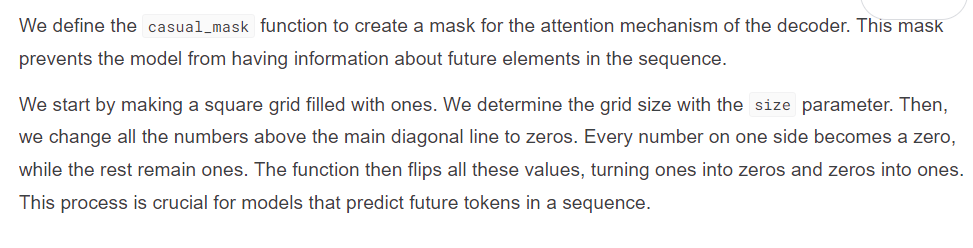

In [36]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

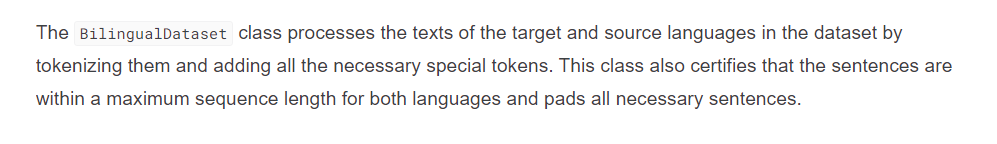

In [37]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }

**Validation Loop**

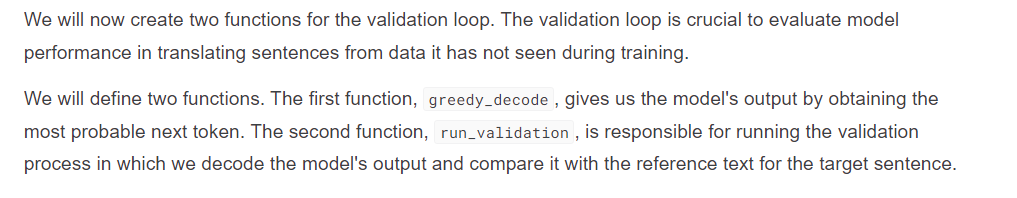

In [38]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [39]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

**Training Loop**

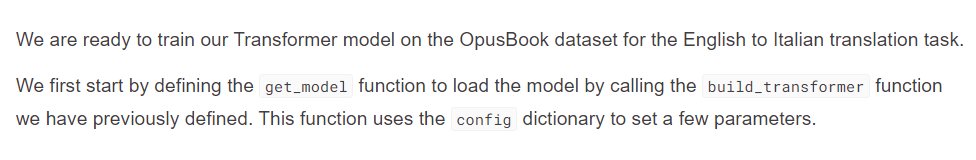

In [40]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

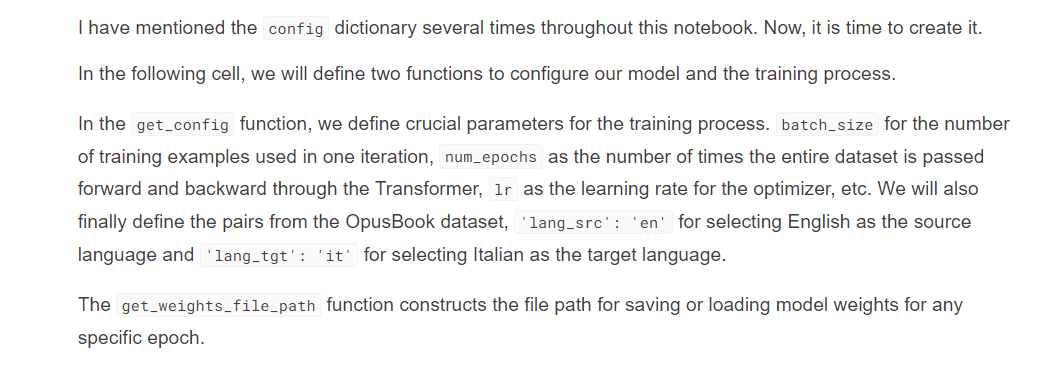

In [41]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

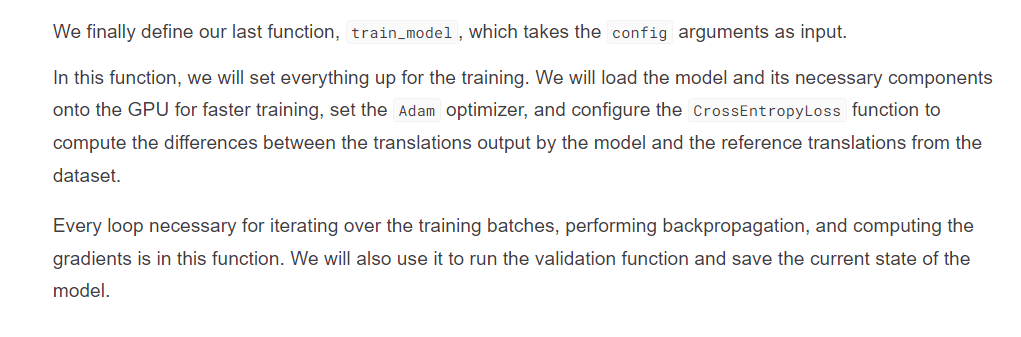

In [44]:
def train_model(config):

    # Device Setup
    if torch.backends.mps.is_available():
        device=torch.device("mps")
    elif torch.cuda.is_available():
        device=torch.device("cuda")
    else:
        device=torch.device("cpu")
    print(f"Using device {device}")

    # Model Dir
    Path(config['model_folder']).mkdir(parents=True,exist_ok=True)

    # Data
    train_dataloader,val_dataloader,tokenizer_src,tokenizer_tgt=get_ds(config)

    # Model
    model=get_model(config,tokenizer_src.get_vocab_size(),tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer=SummaryWriter(config['experiment_name'])

    # Optimizer
    optimizer=torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

    # State
    initial_epoch=0
    global_step=0

    # Load Checkpoint
    if config['preload']:
        model_filename=get_weights_file_path(config,config['preload'])
        print(f'Preloading model {model_filename}')
        state=torch.load(model_filename,map_location=device)

        model.load_state_dict(state['model_state_dict'])
        optimizer.load_state_dict(state['optimizer_state_dict'])
        initial_epoch=state['epoch']+1
        global_step=state['global_step']

    # Loss
    loss_fn=nn.CrossEntropyLoss(
        ignore_index=tokenizer_tgt.token_to_id('[PAD]'),
        label_smoothing=0.1
    ).to(device)

    # Training Loop
    for epoch in range(initial_epoch,config['num_epochs']):

        batch_iterator=tqdm(train_dataloader,desc=f'Processing epoch {epoch:02d}')

        for batch in batch_iterator:
            model.train()

            encoder_input=batch['encoder_input'].to(device)
            decoder_input=batch['decoder_input'].to(device)
            encoder_mask=batch['encoder_mask'].to(device)
            decoder_mask=batch['decoder_mask'].to(device)
            label=batch['label'].to(device)

            encoder_output=model.encode(encoder_input,encoder_mask)
            decoder_output=model.decode(encoder_output,encoder_mask,decoder_input,decoder_mask)
            proj_output=model.project(decoder_output)

            loss=loss_fn(
                proj_output.view(-1,tokenizer_tgt.get_vocab_size()),
                label.view(-1)
            )

            batch_iterator.set_postfix({"loss":f"{loss.item():6.3f}"})
            writer.add_scalar('train loss',loss.item(),global_step)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            global_step+=1

        # Validation
        run_validation(
            model,
            val_dataloader,
            tokenizer_src,
            tokenizer_tgt,
            config['seq_len'],
            device,
            lambda msg: batch_iterator.write(msg),
            global_step,
            writer
        )

        # Save
        model_filename=get_weights_file_path(config,f'{epoch:02d}')
        torch.save({
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'global_step':global_step
        },model_filename)

Lets train the model now

In [45]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

Using device mps


Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00: 100%|██████████| 3638/3638 [2:38:11<00:00,  2.61s/it, loss=5.436]    


--------------------------------------------------------------------------------
SOURCE: In reality he had begun to feel dissatisfied about the time that he went to Moscow the year before.
TARGET: Ma, in fondo, fin dall’anno scorso, quando era andato a Mosca, aveva cessato di esserlo.
PREDICTED: Il suo momento non era un ’ altro che non era un ’ altro di lui .
--------------------------------------------------------------------------------
SOURCE: There is no folly so besotted that the idiotic rivalries of society, the prurience, the rashness, the blindness of youth, will not hurry a man to its commission.
TARGET: Non vi è nulla che trascini un uomo quanto le stupide rivalità della società, i desiderii febbrili e l'acciecamento giovanile.
PREDICTED: Ma non è un uomo , ma non si , e che non si , ma non si , ma non si .


Processing epoch 01: 100%|██████████| 3638/3638 [3:47:22<00:00,  3.75s/it, loss=4.562]     


--------------------------------------------------------------------------------
SOURCE: I was agreeably surprised to see it, and said to myself, that certainly they might be made to burn whole, if they would burn broken.
TARGET: Rimasi gratamente sorpreso a tal vista, perchè pensai che sicuramente si potea far cuocere tutto un vaso, se era atto a cuocersi un pezzo di esso.
PREDICTED: Io mi , e mi , e mi disse : — , come , come .
--------------------------------------------------------------------------------
SOURCE: Levin drew near.
TARGET: Levin si fece dappresso.
PREDICTED: Levin si fermò .


Processing epoch 02: 100%|██████████| 3638/3638 [5:52:17<00:00,  5.81s/it, loss=5.365]    


--------------------------------------------------------------------------------
SOURCE: But there was more work to do yet; for I perceived the savage whom I had knocked down was not killed, but stunned with the blow, and began to come to himself: so I pointed to him, and showed him the savage, that he was not dead; upon this he spoke some words to me, and though I could not understand them, yet I thought they were pleasant to hear; for they were the first sound of a man’s voice that I had heard, my own excepted, for above twenty-five years.
TARGET: Ma non eravamo ancora nè egli nè io fuor dell’impaccio, perchè m’accorsi che il selvaggio da me atterrato, non morto, come pensai, ma soltanto sbalordito dalla violenza della percossa, cominciava a riaversi; la qual cosa feci notare al mio protetto, indicandogli a cenni che quel suo nemico era tuttora vivo. Su di ciò egli mi disse alcune parole, le quali, benchè non intendessi punto, mi furono gratissime, siccome il primo suono di voce uman

Processing epoch 03: 100%|██████████| 3638/3638 [1:56:07<00:00,  1.92s/it, loss=4.007]    


--------------------------------------------------------------------------------
SOURCE: 'I hope you believe in my affection for my sister and my sincere attachment and respect for yourself,' said he, blushing.
TARGET: — Spero che tu creda al mio affetto per mia sorella e al sincero legame e alla stima che ho per te — disse, arrossendo.
PREDICTED: — Io , ti la mia sorella , e la mia sorella , e vi , — disse , alzandosi .
--------------------------------------------------------------------------------
SOURCE: And is it that makes you so miserable?
TARGET: E fu quello che vi rese infelice?
PREDICTED: E che è così , che vi è così facile ?


Processing epoch 04: 100%|██████████| 3638/3638 [3:54:54<00:00,  3.87s/it, loss=4.432]     


--------------------------------------------------------------------------------
SOURCE: First it marked out a race-course, in a sort of circle, ('the exact shape doesn't matter,' it said,) and then all the party were placed along the course, here and there.
TARGET: Prima tracciò la linea dello steccato, una specie di circolo, (— che la forma sia esatta o no, non importa, — disse) e poi tutta la brigata entrò nello steccato disponendosi in questo o in quel punto.
PREDICTED: Prima di , si , e si in un ’ altra , si — disse il Re , e si in giro .
--------------------------------------------------------------------------------
SOURCE: Turning now to the opposite characters of Commodus, Severus, Antoninus Caracalla, and Maximinus, you will find them all cruel and rapacious-men who, to satisfy their soldiers, did not hesitate to commit every kind of iniquity against the people; and all, except Severus, came to a bad end; but in Severus there was so much valour that, keeping the soldiers frie

Processing epoch 05: 100%|██████████| 3638/3638 [1:28:38<00:00,  1.46s/it, loss=3.679]


--------------------------------------------------------------------------------
SOURCE: 'What have I discovered?' he asked himself, turning back the leaf that it should not hinder the insect and bending another blade for the creature to pass on to. 'What gladdens me?
TARGET: “Che cosa ho scoperto? — si domandò, voltando dall’altra parte lo stelo perché non disturbasse lo scarabeo, e piegando un altro filo d’erba perché lo scarabeo passasse su di esso. — Che cosa mi rallegra? che cosa ho mai scoperto?
PREDICTED: — Che ho fatto ? — chiese , volgendosi a guardare il velo , che non si poteva , e , per la forza di un altro uccello di cui mi ?
--------------------------------------------------------------------------------
SOURCE: 'Once,' said the Mock Turtle at last, with a deep sigh, 'I was a real Turtle.'
TARGET: — Una volta, — disse finalmente la Falsa-testuggine con un gran sospiro, — io ero una testuggine vera.
PREDICTED: — Un ' altra frase , — disse la Falsa - testuggine , — è un po 

Processing epoch 06: 100%|██████████| 3638/3638 [1:21:08<00:00,  1.34s/it, loss=4.256]


--------------------------------------------------------------------------------
SOURCE: CHAPTER XVII
TARGET: XVII
PREDICTED: XVII
--------------------------------------------------------------------------------
SOURCE: Nowadays girls all want to trust to their own reason. They don't tell their mothers anything, and then...
TARGET: Oggigiorno vogliono fare di testa loro, non dicono nulla alla mamma, e poi, ecco...
PREDICTED: In quel momento la loro occasione si la possibilità di dire : “ , allora non si nulla ”.


Processing epoch 07: 100%|██████████| 3638/3638 [1:46:21<00:00,  1.75s/it, loss=3.432]    


--------------------------------------------------------------------------------
SOURCE: The sight of Vronsky's tears made Karenin aware of the approach of that mental perturbation which other people's visible sufferings always aroused in him, and turning away his head he went toward the door without heeding what Vronsky was saying.
TARGET: Aleksej Aleksandrovic, viste le lacrime di Vronskij, sentì un afflusso di quello sconvolgimento d’animo che produceva in lui la vista della sofferenza altrui, e voltando il viso, senza finir di ascoltare le sue parole, si avviò in fretta verso la porta.
PREDICTED: Il suo sguardo di Vronskij si illuminò di lui che gli occhi di Aleksej Aleksandrovic si era di nuovo il pensiero di lui , e che , sempre più , si avvicinò alla porta , si fermò senza guardare Vronskij .
--------------------------------------------------------------------------------
SOURCE: He turned to Sappho: 'You have lost the bet: we have arrived first.
TARGET: Si rivolse a Safo: — La 

Processing epoch 08: 100%|██████████| 3638/3638 [1:34:34<00:00,  1.56s/it, loss=2.831]


--------------------------------------------------------------------------------
SOURCE: 'The fact of the matter is, you see, that progress can only be achieved by authority,' he said, evidently wishing to show that education was not foreign to him. 'Take for instance, the reforms of Peter the Great, Catherine, and Alexander.
TARGET: — La questione, permettetemi di osservare, è che ogni progresso lo si attua solo d’autorità — egli disse evidentemente per mostrare che anche lui non era estraneo alla cultura. — Prendete le riforme di Pietro, di Caterina, di Alessandro.
PREDICTED: — La cosa è il fatto che si vede , che si può vedere soltanto essere in modo particolare — disse , evidentemente , evidentemente l ’ educazione dei buoni consigli — e , per favore , per favore del consiglio distrettuale , e per favore del consiglio distrettuale .
--------------------------------------------------------------------------------
SOURCE: He rang, and despatched an invitation to Mrs. Fairfax, who soo

Processing epoch 09: 100%|██████████| 3638/3638 [1:20:10<00:00,  1.32s/it, loss=3.212]


--------------------------------------------------------------------------------
SOURCE: A dream had scarcely approached my ear, when it fled affrighted, scared by a marrow-freezing incident enough.
TARGET: Quando un sogno stava per avvicinarsi a me, era fugato da un rumore spaventoso.
PREDICTED: Un sogno non mi si vedeva , quando la mia volontà si .
--------------------------------------------------------------------------------
SOURCE: I--'
TARGET: Io...
PREDICTED: Io ...


Processing epoch 10: 100%|██████████| 3638/3638 [1:11:57<00:00,  1.19s/it, loss=3.579]


--------------------------------------------------------------------------------
SOURCE: 'Tell her we have not got a cheap sale on here!' he said and came back again.
TARGET: — Ditele che non siamo al mercato! — disse e ritornò da Aleksej Aleksandrovic.
PREDICTED: — E noi non abbiamo fatto la vendita di qui ! — egli disse e uscì .
--------------------------------------------------------------------------------
SOURCE: The head of my bed was near the door, and I thought at first the goblin-laugher stood at my bedside--or rather, crouched by my pillow: but I rose, looked round, and could see nothing; while, as I still gazed, the unnatural sound was reiterated: and I knew it came from behind the panels.
TARGET: La testa del letto era prossima alla porta, e per un momento credei che il demonio, che aveva manifestato la sua presenza, fosse al mio capezzale. Allora mi alzai, guardai senza veder nulla.
PREDICTED: La testa era accanto alla porta , e pensavo che il signor Edoardo fosse .


Processing epoch 11: 100%|██████████| 3638/3638 [1:16:11<00:00,  1.26s/it, loss=2.865]


--------------------------------------------------------------------------------
SOURCE: Dolly was dazzled by the elegant equipage of a kind she had never seen, by the beautiful horses and the elegant, brilliant persons about her.
TARGET: Dar’ja Aleksandrovna era abbagliata da quella vettura elegante non mai vista da lei, da quei cavalli bellissimi, da quelle persone mondane, raffinate che la circondavano.
PREDICTED: Dolly era nei racconti delle fate , ma non aveva visto mai , nei racconti dei giovani e dei giovani .
--------------------------------------------------------------------------------
SOURCE: She sat down and he could hear her loud, heavy breathing. He felt unutterably sorry for her.
TARGET: Ella si mise a sedere. Egli sentiva il respiro grave di lei e gliene veniva una pena indicibile.
PREDICTED: Sedette e sentiva che le sue parole le si sentiva sospesa , ch ’ egli sentiva di continuo pena .


Processing epoch 12: 100%|██████████| 3638/3638 [8:48:49<00:00,  8.72s/it, loss=2.856]      


--------------------------------------------------------------------------------
SOURCE: Her thoughts seemed strange to her.
TARGET: Erano strani anche per lei i suoi pensieri.
PREDICTED: Le sue idee le dissero a lei .
--------------------------------------------------------------------------------
SOURCE: I have wholly forgiven – I want to turn the other cheek – I want to give my cloak because my coat has been taken.
TARGET: Voglio porgere l’altra guancia, voglio dare la tunica quando mi si è preso il mantello.
PREDICTED: Io ho perdonato , ho perdonato , voglio dare alle lagrime ; devo dare un mantello per me .


Processing epoch 13: 100%|██████████| 3638/3638 [1:30:43<00:00,  1.50s/it, loss=3.318]


--------------------------------------------------------------------------------
SOURCE: Mrs. Fairfax has said something, perhaps? or you have overheard the servants talk?--your sensitive self-respect has been wounded?"
TARGET: La signora Fairfax vi ha detto qualcosa, oppure avete udita una conversazione scambiata fra domestici? La vostra dignità troppo suscettibile ne è stata offesa?
PREDICTED: La signora Fairfax ha detto qualcosa , forse avete sentito qualcosa di voi , o forse avete sentito parlare di voi ?
--------------------------------------------------------------------------------
SOURCE: "Yes, sir."
TARGET: — Molto strana, signore.
PREDICTED: — Sì , signore .


Processing epoch 14: 100%|██████████| 3638/3638 [1:22:18<00:00,  1.36s/it, loss=2.653]


--------------------------------------------------------------------------------
SOURCE: What secret can Steve have from me?'
TARGET: Che mistero può esistere tra Stiva e me?
PREDICTED: Che posso Stiva può da me ?
--------------------------------------------------------------------------------
SOURCE: A little boy dressed in a Russian costume, violently swinging his arms and stooping very low, was overtaking her.
TARGET: Un ragazzo in costume russo, che gesticolava in maniera disperata e si piegava verso terra, la sorpassò.
PREDICTED: Un ragazzo , in un vestito russo , con le braccia piene , con le braccia , si avvicinavano e si gambe .


Processing epoch 15: 100%|██████████| 3638/3638 [1:44:41<00:00,  1.73s/it, loss=2.701]    


--------------------------------------------------------------------------------
SOURCE: He uses these words but understands nothing about the business.'
TARGET: Ripete delle parole, ma non ne conosce il senso».
PREDICTED: di queste parole e di nulla .
--------------------------------------------------------------------------------
SOURCE: Of course there was love too; but the greater part was pride in his success.
TARGET: S’intende, c’era anche l’amore, ma la parte maggiore era l’orgoglio del successo.
PREDICTED: Naturalmente era troppo innamorato , ma era il suo preferito .


Processing epoch 16: 100%|██████████| 3638/3638 [1:53:47<00:00,  1.88s/it, loss=2.549]   


--------------------------------------------------------------------------------
SOURCE: 'Ah, so you are here!' she said on seeing him. 'Well, how is your poor sister?
TARGET: — Ah, anche voi siete qui — ella disse nel vederlo. — Be’, come va la vostra povera sorella?
PREDICTED: — Ah , ecco , eccolo ! — disse lei , vedendo il nome di vostra sorella . — Su , che nome mio !
--------------------------------------------------------------------------------
SOURCE: 'I have been thinking and thinking.
TARGET: — Ho pensato e ho pensato.
PREDICTED: — Mi pare di pensare e di conoscerla .


Processing epoch 17: 100%|██████████| 3638/3638 [2:54:39<00:00,  2.88s/it, loss=2.167]    


--------------------------------------------------------------------------------
SOURCE: As we advanced and left the track, we trod a soft turf, mossy fine and emerald green, minutely enamelled with a tiny white flower, and spangled with a star-like yellow blossom: the hills, meantime, shut us quite in; for the glen, towards its head, wound to their very core.
TARGET: A un certo punto lasciammo il sentiero per avanzarci sull'erba fresca, cosparsa di fiori. Ci trovavamo in una valle circondata da montagne.
PREDICTED: Mentre intorno a noi , un sentiero , le pietre nere e , con i tronchi di verde , il cielo con le montagne . Fui vestita da molte ore , ci sedemmo per parola .
--------------------------------------------------------------------------------
SOURCE: In the next place I went in to fetch my perspective glass to see what I could make of them; and having taken the ladder out, I climbed up to the top of the hill, as I used to do when I was apprehensive of anything, and to take my 

Processing epoch 18: 100%|██████████| 3638/3638 [2:06:53<00:00,  2.09s/it, loss=2.023]  


--------------------------------------------------------------------------------
SOURCE: When he had conducted his sister-in-law to her seat, he took his station behind a pillar, resolved to listen as attentively and as conscientiously as possible.
TARGET: Dopo aver accompagnato la cognata alla sua poltrona, si pose in piedi vicino a una colonna e decise di ascoltare nel modo più attento e coscienzioso possibile.
PREDICTED: Quando egli si era imbattuto con la cognata , si era avvicinato alla stazione da viaggio , nell ’ urna , un più pieno di sforzo e di sforzo come meglio .
--------------------------------------------------------------------------------
SOURCE: "Yes--yes; open quickly."
TARGET: — Sì, sì; aprite presto!
PREDICTED: — Sì , sì , lo udii subito .


Processing epoch 19: 100%|██████████| 3638/3638 [1:29:11<00:00,  1.47s/it, loss=2.646]


--------------------------------------------------------------------------------
SOURCE: The only thing to be done was to sit and wait until someone came by.
TARGET: L’unica cosa da fare era sederci e aspettare che qualcuno ci passasse accanto.
PREDICTED: E ora , solo , s ’ era fatto poco da sedere e poi , dopo aver bevuto .
--------------------------------------------------------------------------------
SOURCE: She was breathing heavily and not looking at him.
TARGET: Lei respirava con affanno, senza guardarlo.
PREDICTED: Ella era nervosamente con non guardarlo a guardarlo .
